In [5]:
import numpy as np
from phimal_utilities.analysis import load_tensorboard

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='white')

In [43]:
df_deepmod = load_tensorboard('runs/deepmod/')
df_logprob= load_tensorboard('runs/logprob/')
df_logprob_scaled = load_tensorboard('runs/logprob_scaled/')

In [45]:
df_logprob_scaled.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'coeff_0_9', 'coeff_0_10', 'coeff_0_11',
       'scaled_coeff_0_0', 'scaled_coeff_0_1', 'scaled_coeff_0_2',
       'scaled_coeff_0_3', 'scaled_coeff_0_4', 'scaled_coeff_0_5',
       'scaled_coeff_0_6', 'scaled_coeff_0_7', 'scaled_coeff_0_8',
       'scaled_coeff_0_9', 'scaled_coeff_0_10', 'scaled_coeff_0_11',
       'log_likelihood', 'll_fit'],
      dtype='object')

In [54]:
true_coeffs = np.zeros((1, 12))
true_coeffs[0, 2] = 0.1
true_coeffs[0, 5] = -1.0

In [55]:
coeff_keys = [key for key in df_deepmod.keys() if key[:5]=='coeff']

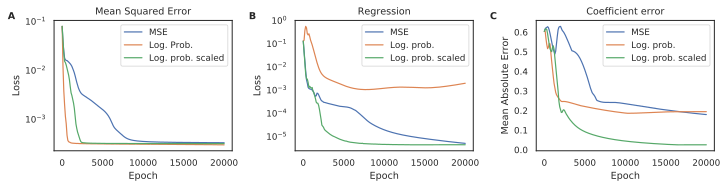

In [116]:
%config InlineBackend.figure_format = 'svg'

sns.set_context('paper')
sns.set_style('white')

fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=3, constrained_layout=True) #5.5 is official width

# Left panel
ax = axes[0]
ax.plot(df_deepmod.index, df_deepmod['MSE_0'], label='MSE')
ax.plot(df_logprob.index, df_logprob['MSE_0'], label='Log. Prob.')
ax.plot(df_logprob_scaled.index, df_logprob_scaled['MSE_0'], label='Log. prob. scaled')

ax.legend()
ax.set_yscale('log')
ax.set_title('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.text(-0.26, 1.01, 'A', transform=ax.transAxes, weight='bold')

# Middle panel
ax = axes[1]
ax.plot(df_deepmod.index, df_deepmod['Regression_0'], label='MSE')
ax.plot(df_logprob.index, df_logprob['Regression_0'], label='Log. prob.')
ax.plot(df_logprob_scaled.index, df_logprob_scaled['Regression_0'], label='Log. prob. scaled')

ax.legend()
ax.set_yscale('log')
ax.set_title('Regression')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.text(-0.26, 1.01, 'B', transform=ax.transAxes, weight='bold')

# Right panel
ax = axes[2]
ax.plot(df_deepmod.index, np.mean(np.abs(df_deepmod[coeff_keys] - true_coeffs), axis=1), label='MSE')
ax.plot(df_logprob.index, np.mean(np.abs(df_logprob[coeff_keys] - true_coeffs), axis=1), label='Log. prob.')
ax.plot(df_logprob_scaled.index, np.mean(np.abs(df_logprob_scaled[coeff_keys] - true_coeffs), axis=1), label='Log. prob. scaled')
ax.set_title('Coefficient error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.text(-0.26, 1.01, 'C', transform=ax.transAxes, weight='bold')
ax.legend()

#fig.show()
plt.savefig('figure_1.pdf')

# Loading multiple runs

In [1]:
import numpy as np
from phimal_utilities.analysis import load_tensorboard
from os import listdir
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='white')


In [64]:
def collect_runs(ID, true_coeffs):
    files = [file for file in listdir('runs') if file[:len(ID)] == ID]
    files.sort()
    print(files)
    dfs = [load_tensorboard('runs/' + file + '/') for file in files]
    
    df_plot = pd.DataFrame(index=dfs[0].index)
    
    # Setting MSE and Reg properties
    MSE = np.log10(np.stack([df['MSE_0'] for df in dfs], axis=1)) # take mean of log ipv log of mean for visualization purposes
    Reg = np.log10(np.stack([df['Regression_0'] for df in dfs], axis=1))
    
    df_plot['MSE_mean'] = np.mean(MSE, axis=1)
    df_plot['MSE_std'] = np.std(MSE, axis=1)
    df_plot['Reg_mean'] = np.mean(Reg, axis=1)
    df_plot['Reg_std'] = np.std(Reg, axis=1)
    
    # Coefficient error 
    coeff_keys = [key for key in dfs[0].keys() if key[:5]=='coeff']
    coeff_errors = np.stack([np.mean(np.abs(df[coeff_keys] - true_coeffs), axis=1) for df in dfs], axis=1)
    df_plot['Coeff_mean'] = np.mean(coeff_errors, axis=1)
    df_plot['Coeff_std'] = np.std(coeff_errors, axis=1)
    
    return df_plot

In [65]:
true_coeffs = np.zeros((1, 12))
true_coeffs[0, 2] = 0.1
true_coeffs[0, 5] = -1.0

In [66]:
df_deepmod = collect_runs('deepmod_run', true_coeffs=true_coeffs)
df_logprob = collect_runs('deepmod_logprob_run', true_coeffs=true_coeffs)
df_logprob_scaled = collect_runs('deepmod_logprob_scaled_run', true_coeffs=true_coeffs)

['deepmod_run_0', 'deepmod_run_1', 'deepmod_run_2', 'deepmod_run_3', 'deepmod_run_4']
['deepmod_logprob_run_0', 'deepmod_logprob_run_1', 'deepmod_logprob_run_2', 'deepmod_logprob_run_3', 'deepmod_logprob_run_4']
['deepmod_logprob_scaled_run_0', 'deepmod_logprob_scaled_run_1', 'deepmod_logprob_scaled_run_2', 'deepmod_logprob_scaled_run_3', 'deepmod_logprob_scaled_run_4']


In [68]:
df_deepmod.keys()

Index(['MSE_mean', 'MSE_std', 'Reg_mean', 'Reg_std', 'Coeff_mean',
       'Coeff_std'],
      dtype='object')

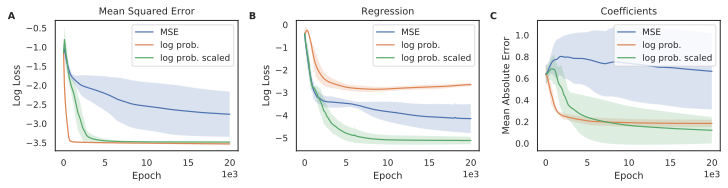

In [71]:
%config InlineBackend.figure_format = 'svg'

sns.set_context('paper')
sns.set_style('white')

fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=3, constrained_layout=True) #5.5 is official width

# Left panel
ax = axes[0]

ax.fill_between(df_deepmod.index, df_deepmod['MSE_mean']-df_deepmod['MSE_std'], df_deepmod['MSE_mean']+df_deepmod['MSE_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['MSE_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['MSE_mean']-df_logprob['MSE_std'], df_logprob['MSE_mean']+df_logprob['MSE_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['MSE_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['MSE_mean']-df_logprob_scaled['MSE_std'], df_logprob_scaled['MSE_mean']+df_logprob_scaled['MSE_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['MSE_mean'], label='log prob. scaled')

ax.legend()
ax.set_title('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Log Loss')
ax.text(-0.26, 1.01, 'A', transform=ax.transAxes, weight='bold')
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))

# Middle panel
ax = axes[1]
ax.fill_between(df_deepmod.index, df_deepmod['Reg_mean']-df_deepmod['Reg_std'], df_deepmod['Reg_mean']+df_deepmod['Reg_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['Reg_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['Reg_mean']-df_logprob['Reg_std'], df_logprob['Reg_mean']+df_logprob['Reg_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['Reg_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['Reg_mean']-df_logprob_scaled['Reg_std'], df_logprob_scaled['Reg_mean']+df_logprob_scaled['Reg_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['Reg_mean'], label='log prob. scaled')

ax.legend()
ax.set_title('Regression')
ax.set_xlabel('Epoch')
ax.set_ylabel('Log Loss')
ax.text(-0.26, 1.01, 'B', transform=ax.transAxes, weight='bold')
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))


# Right panel
ax = axes[2]
ax.fill_between(df_deepmod.index, df_deepmod['Coeff_mean']-df_deepmod['Coeff_std'], df_deepmod['Coeff_mean']+df_deepmod['Coeff_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['Coeff_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['Coeff_mean']-df_logprob['Coeff_std'], df_logprob['Coeff_mean']+df_logprob['Coeff_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['Coeff_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['Coeff_mean']-df_logprob_scaled['Coeff_std'], df_logprob_scaled['Coeff_mean']+df_logprob_scaled['Coeff_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['Coeff_mean'], label='log prob. scaled')

ax.set_title('Coefficients')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.text(-0.26, 1.01, 'C', transform=ax.transAxes, weight='bold')
ax.legend()
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))

fig.show()
plt.savefig('figure_1.pdf')